In [37]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

warnings.simplefilter(action="ignore", category=FutureWarning)
import sys

sys.path.append("../")

import optuna

from straindesignxai.main import DataLoader

RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

Dataset size: (30, 10)
New data shape: (27, 10)


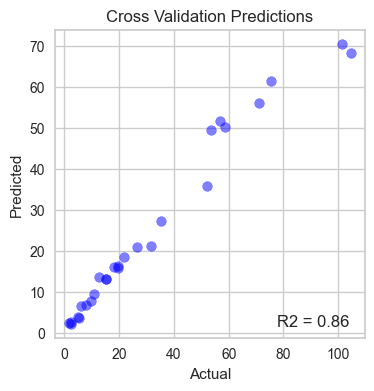

In [38]:
dl = DataLoader(PATH, INPUT_VARS, RESPONSE_VARS)
dl.get_bounds()

cycle = 'DBTL_A'
# cycle = 'all'

if cycle == 'DBTL_A':
    # Keep only DBTL_A indexes
    dl.df = dl.df[dl.df.index.isin(DBTL_A)]
    dl.X = dl.df[INPUT_VARS]
    dl.y = dl.df[RESPONSE_VARS]
    print(f"New data shape: {dl.df.shape}")

    try:
        dl.load_model("../models/xgb_limonene.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene.pkl")

elif cycle == 'all':
    try:
        dl.load_model("../models/xgb_limonene_all.pkl")
    except FileNotFoundError:
        dl.train_xgb(n_iter=300)
        dl.save_model("../models/xgb_limonene_all.pkl")    
    
dl.plot_R2()

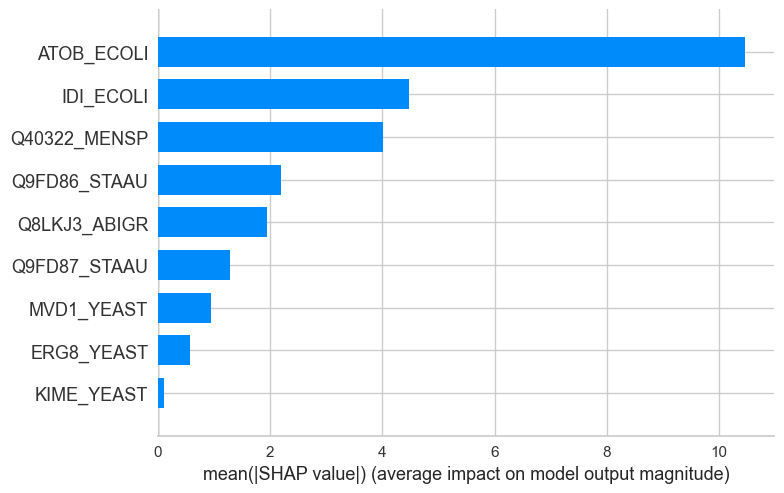

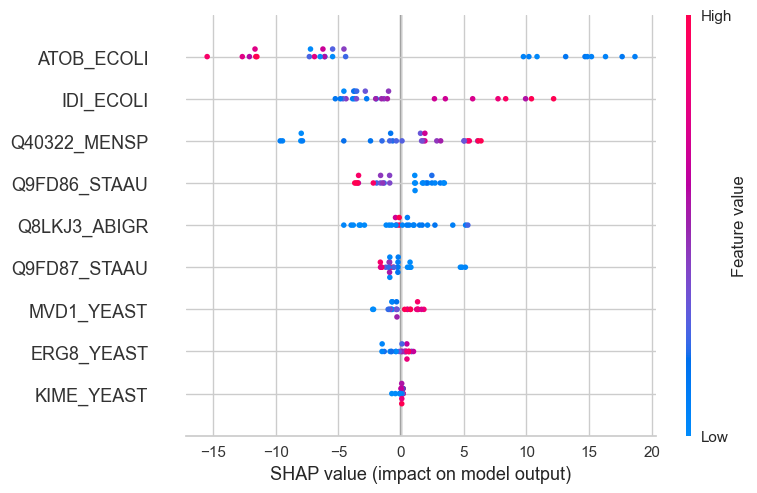

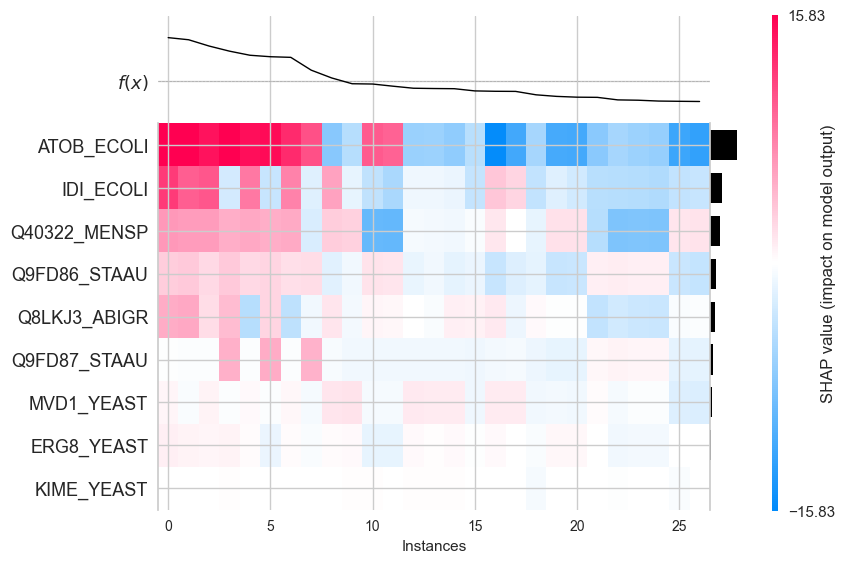

In [39]:
dl.get_shap_values()

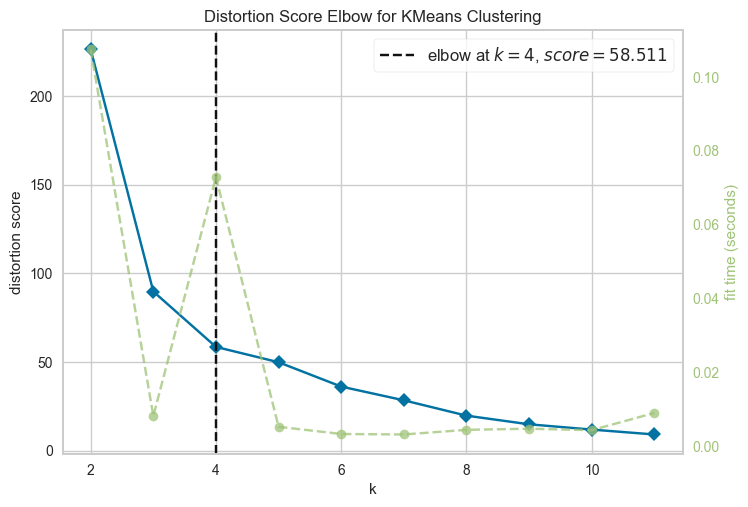

Optimal number of clusters: 4


In [4]:
dl.supervised_clustering()

In [5]:
dl.study_clusters()

Number of elements in each cluster: 
cluster
0    14
3     5
1     5
2     3
Name: count, dtype: int64


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.664971,0.666893,1.338579,0.254064,1.230621,3.749186,1.084307,1.563443,2.050229,10.931601
1,0.206480,0.707940,2.525160,0.330960,1.730520,8.523380,0.420080,0.540460,0.564080,78.341800
2,0.912200,0.707467,2.075733,0.308667,1.695533,4.429967,0.394533,2.661100,3.197000,21.957007
3,0.119180,0.311060,1.082380,0.151280,0.762520,3.047580,0.356020,0.160800,0.248800,46.023752


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.664971,0.666893,1.338579,0.254064,1.230621,3.749186,1.084307,1.563443,2.050229,10.931601
1,0.206480,0.707940,2.525160,0.330960,1.730520,8.523380,0.420080,0.540460,0.564080,78.341800
2,0.912200,0.707467,2.075733,0.308667,1.695533,4.429967,0.394533,2.661100,3.197000,21.957007
3,0.119180,0.311060,1.082380,0.151280,0.762520,3.047580,0.356020,0.160800,0.248800,46.023752


### Study top producting cluster

In [6]:
dl.df["pred"] = dl.model.predict(dl.df.drop(["Limonene", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    dl.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)

dl.df[dl.df["cluster"] == top_cluster]

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene,cluster,pred
2X.Lm,0.1720,0.6213,2.5226,0.3043,1.6258,8.4749,0.2245,0.4305,0.4944,56.97134,1,51.756355
2X.Lh,0.2335,0.7463,2.3338,0.3196,1.7450,9.1728,0.2534,0.6998,0.6607,53.60310,1,49.505325
2X.Mm,0.2231,0.7901,2.7354,0.3744,1.9592,9.2338,0.4335,0.5118,0.5409,101.20540,1,70.643181
2X.Mh,0.2384,0.9413,3.1813,0.4010,2.1936,11.2037,0.2968,0.7816,0.7488,75.39261,1,61.636490
B.Ml,0.1654,0.4407,1.8527,0.2555,1.1290,4.5317,0.8922,0.2786,0.3756,104.53655,1,68.364120


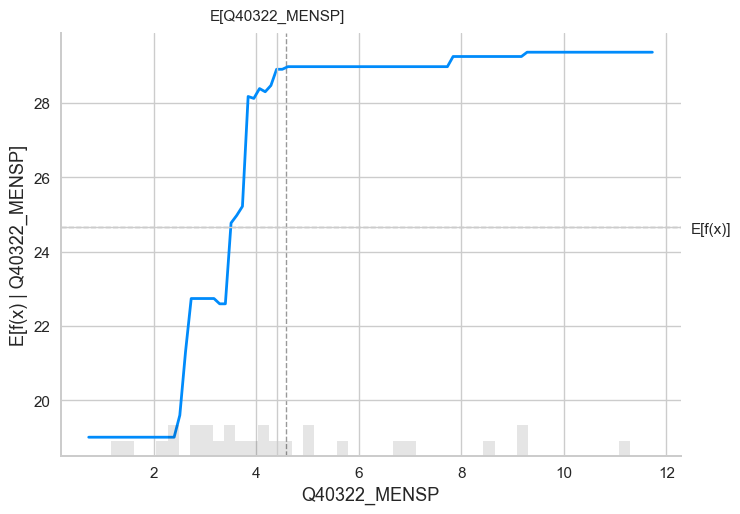

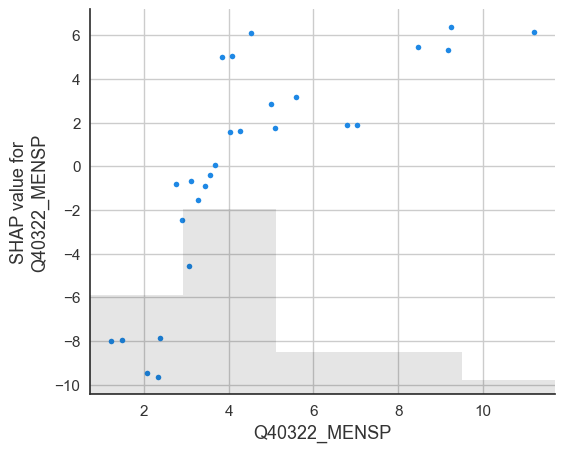

In [7]:
dl.pdplot("Q40322_MENSP")
dl.shap_scatter("Q40322_MENSP")

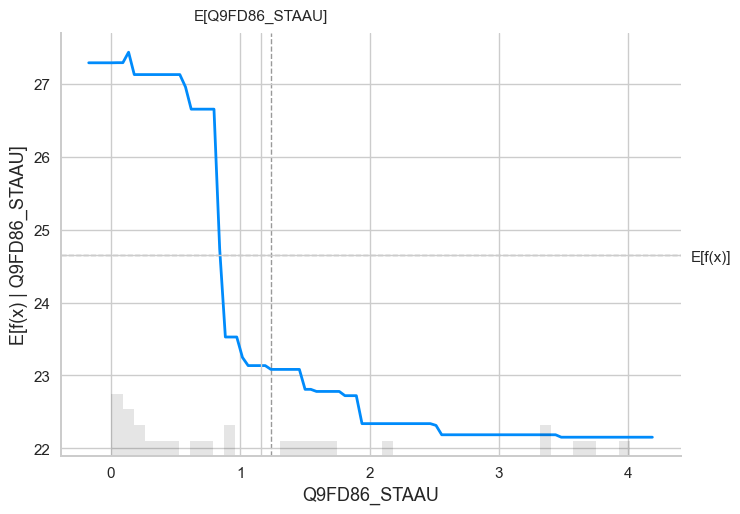

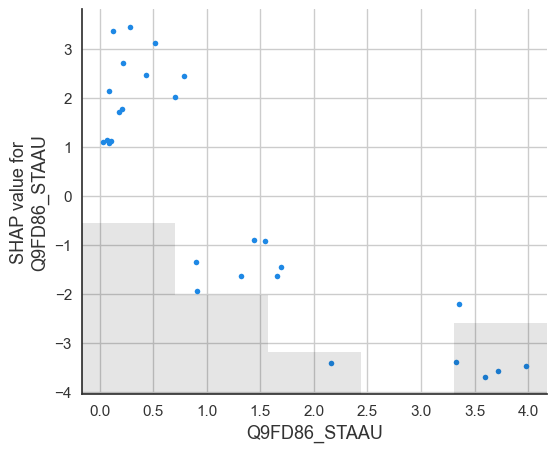

In [8]:
dl.pdplot("Q9FD86_STAAU")
dl.shap_scatter("Q9FD86_STAAU")

## Sampling

In [9]:
from scipy.stats import qmc

# Rearrange bounds to match input variables
# dl.bounds['Q40322_MENSP'].loc['min'] = 14
# dl.bounds['Q9FD86_STAAU'].loc['max'] = 0.3
# dl.bounds['ERG8_YEAST'].loc['max'] = 0.5

sampler = qmc.LatinHypercube(d=dl.X.shape[1])
sample = sampler.random(100)
LB = dl.bounds.T['min'].values.tolist()
UB = dl.bounds.T['max'].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=dl.X.columns)
sample_df["pred"] = dl.model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(3)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
11,0.156839,0.888467,2.040291,1.392100,1.107819,4.984781,1.396141,0.455108,4.156285,67.611374
86,0.134450,1.306548,2.767924,1.042323,1.056182,13.117363,0.436372,3.453661,3.852320,60.461365
66,0.175209,0.902036,2.072265,1.217074,1.535726,8.984809,0.989881,1.870711,0.646637,59.827053


In [17]:
from nbsynthetic.data_preparation import SmartBrain
from nbsynthetic.vgan import GAN
from nbsynthetic.synthetic import synthetic_data

best_df = dl.df[dl.df["cluster"] == top_cluster]
best_df.drop(['Limonene', 'cluster', 'pred'], axis=1, inplace=True)

SB = SmartBrain()
df = SB.nbEncode(best_df)

samples = 1000
new_df = synthetic_data(GAN, df, samples=samples, show_tqdm=False)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 98ms/step


Epoch (1/10) | D. loss: 0.67 | G. loss: 0.68 |: 100%|##########| 1/1 [00:03<00:00,  3.61s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch (2/10) | D. loss: 0.70 | G. loss: 0.70 |: 100%|##########| 1/1 [00:00<00:00,  5.69it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Epoch (3/10) | D. loss: 0.69 | G. loss: 0.71 |: 100%|##########| 1/1 [00:00<00:00,  4.45it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Epoch (4/10) | D. loss: 0.68 | G. loss: 0.69 |: 100%|##########| 1/1 [00:00<00:00,  5.45it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch (5/10) | D. loss: 0.70 | G. loss: 0.71 |: 100%|##########| 1/1 [00:00<00:00,  5.41it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch (6/10) | D. loss: 0.69 | G. loss: 0.67 |: 100%|##########| 1/1 [00:00<00:00,  5.46it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch (7/10) | D. loss: 0.69 | G. loss: 0.69 |: 100%|##########| 1/1 [00:00<00:00,  5.30it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch (8/10) | D. loss: 0.68 | G. loss: 0.67 |: 100%|##########| 1/1 [00:00<00:00,  5.61it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch (9/10) | D. loss: 0.67 | G. loss: 0.68 |: 100%|##########| 1/1 [00:00<00:00,  5.98it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch (10/10) | D. loss: 0.68 | G. loss: 0.68 |: 100%|##########| 1/1 [00:00<00:00,  5.39it/s]


32/32 [==============================] - 0s 5ms/step


In [18]:
from nbsynthetic.statistics import mmd_rbf, Wilcoxon, Student_t, Kolmogorov_Smirnov

mmd_rbf(best_df, new_df, gamma=None)
# Wilcoxon(df, new_df)
# Student_t(df, new_df)
# Kolmogorov_Smirnov(df, new_df)

new_df['Limonene'] = dl.model.predict(new_df)
new_df.sort_values('Limonene', ascending=False, inplace=True)

Maximum Mean Discrepance = 0.15048


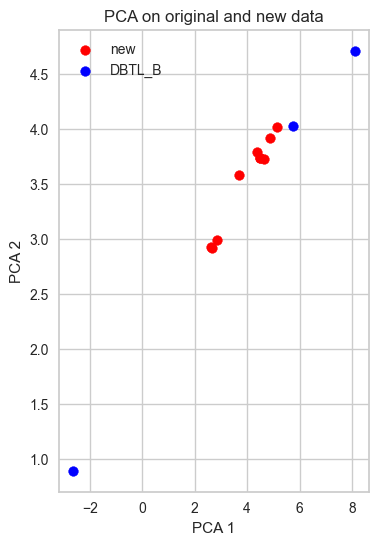

In [33]:
# Keep only indexes in DBTL_B
original_df = pd.read_csv(PATH, index_col=0)
original_df = original_df[INPUT_VARS + RESPONSE_VARS]
dbtl_b = original_df[original_df.index.isin(DBTL_B)]

# Perform PCA on original data

pca = PCA(n_components=2)
pca.fit(dl.df[INPUT_VARS])
dl.df['pca1'] = pca.transform(dl.df[INPUT_VARS])[:,0]
dl.df['pca2'] = pca.transform(dl.df[INPUT_VARS])[:,1]

rec_df = new_df.head(10)

# Perform PCA on new data
rec_df['pca1'] = pca.transform(rec_df[INPUT_VARS])[:,0]
rec_df['pca2'] = pca.transform(rec_df[INPUT_VARS])[:,1]
dbtl_b['pca1'] = pca.transform(dbtl_b[INPUT_VARS])[:,0]
dbtl_b['pca2'] = pca.transform(dbtl_b[INPUT_VARS])[:,1]

# Plot PCA
fig, ax = plt.subplots(figsize=(4,6))
ax.scatter(rec_df['pca1'], rec_df['pca2'],  color='red')
ax.scatter(dbtl_b['pca1'], dbtl_b['pca2'],  color='blue')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('PCA on original and new data')
ax.legend(['new', 'DBTL_B'])
plt.show()


In [34]:
# Concat original and new data
rec_df = pd.concat([rec_df, dbtl_b], axis=0)
rec_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene,pca1,pca2
238,0.168582,0.752716,3.169323,0.346571,1.789873,9.245527,0.360569,0.440262,0.470469,70.741508,3.676429,3.578559
54,0.183876,0.695165,2.899469,0.325648,1.998839,10.026190,0.523679,0.463010,0.558837,70.643181,4.387872,3.789030
655,0.194034,0.660270,2.659266,0.309213,2.084721,10.583603,0.644758,0.526078,0.598783,70.643181,4.888925,3.919827
581,0.189750,0.668017,2.703819,0.309819,2.064447,10.121407,0.645010,0.486578,0.595071,70.643181,4.485718,3.739579
905,0.197372,0.701714,2.698235,0.315745,1.956375,10.120232,0.603952,0.503174,0.593644,70.643181,4.472775,3.734247
101,0.206794,0.583310,2.636489,0.300827,2.142463,10.873991,0.749131,0.456686,0.655447,70.598930,5.157352,4.016557
179,0.218307,0.601553,2.751133,0.305668,2.193600,10.223989,0.892200,0.361695,0.684424,70.598930,4.640398,3.724044
319,0.195289,0.739220,2.698572,0.331075,2.073396,8.267699,0.694319,0.389930,0.514165,70.573143,2.858888,2.991332
651,0.183286,0.774663,2.653633,0.338775,2.038315,8.022169,0.564937,0.451259,0.446336,70.573143,2.605309,2.928296
198,0.190005,0.796272,2.658858,0.334727,1.975664,8.076294,0.605423,0.445054,0.481463,70.573143,2.667952,2.914955


In [36]:
from sklearn.metrics.pairwise import cosine_similarity

pd.DataFrame(cosine_similarity(rec_df), columns=rec_df.index, index=rec_df.index)

,238,54,655,581,905,101,179,319,651,198,BL.Mm,BL.Mh,BL.Ml
238,1.000000,0.999871,0.999629,0.999820,0.999828,0.999451,0.999744,0.999776,0.999676,0.999701,0.998793,0.999080,0.876914
54,0.999871,1.000000,0.999937,0.999992,0.999993,0.999853,0.999967,0.999414,0.999235,0.999275,0.998307,0.998895,0.875888
655,0.999629,0.999937,1.000000,0.999961,0.999958,0.999981,0.999967,0.999012,0.998779,0.998830,0.997836,0.998628,0.874843
581,0.999820,0.999992,0.999961,1.000000,0.999999,0.999892,0.999986,0.999365,0.999175,0.999217,0.998299,0.998924,0.875500
905,0.999828,0.999993,0.999958,0.999999,1.000000,0.999885,0.999978,0.999368,0.999181,0.999224,0.998303,0.998918,0.875354
101,0.999451,0.999853,0.999981,0.999892,0.999885,1.000000,0.999922,0.998742,0.998475,0.998532,0.997507,0.998412,0.874394
179,0.999744,0.999967,0.999967,0.999986,0.999978,0.999922,1.000000,0.999269,0.999055,0.999101,0.998192,0.998882,0.875286
319,0.999776,0.999414,0.999012,0.999365,0.999368,0.998742,0.999269,1.000000,0.999985,0.999990,0.999429,0.999387,0.877492
651,0.999676,0.999235,0.998779,0.999175,0.999181,0.998475,0.999055,0.999985,1.000000,0.999999,0.999474,0.999331,0.877769
198,0.999701,0.999275,0.998830,0.999217,0.999224,0.998532,0.999101,0.999990,0.999999,1.000000,0.999471,0.999346,0.877511


In [ ]:
# from nbsynthetic.statistics import plot_histograms

# plot_histograms(df, new_df)

In [81]:
# Generate synthetic data using Gaussian Mixture Models
from sklearn.mixture import GaussianMixture

n_components = 2 # selected by AIC

gmm = GaussianMixture(n_components=n_components)
gmm.fit(best_df)

rec_df = pd.DataFrame(gmm.sample(10)[0], columns=best_df.columns)
rec_df['pred'] = dl.model.predict(rec_df)
rec_df.sort_values('pred', ascending=False, inplace=True)
rec_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
0,0.221463,0.762141,2.648622,0.369171,1.915948,8.861936,0.460767,0.462073,0.503118,70.343338
8,0.162814,0.440503,1.851757,0.256113,1.129926,4.531046,0.893481,0.278604,0.377224,68.364120
9,0.164220,0.440213,1.853205,0.256080,1.129561,4.533147,0.889517,0.279179,0.374474,68.364120
5,0.257112,0.893496,2.776460,0.398468,2.104371,9.968409,0.460002,0.674733,0.647383,65.127029
2,0.192958,0.730564,2.791999,0.348109,1.850995,9.305619,0.297585,0.502158,0.547093,63.604118
3,0.159611,0.665712,2.893857,0.336262,1.779591,8.989936,0.265237,0.371218,0.471764,53.802876
1,0.213792,0.748553,2.591770,0.334782,1.810289,9.341464,0.267837,0.613765,0.613377,52.468178
6,0.210237,0.774263,2.736692,0.339840,1.861050,9.816574,0.226682,0.657516,0.653490,52.355564
4,0.228509,0.829674,2.780335,0.358876,1.957729,10.099060,0.274004,0.705336,0.684124,51.577148
7,0.240397,0.834791,2.638464,0.351040,1.925591,10.079243,0.259495,0.773706,0.720554,50.482315


In [ ]:
!pip install sdv